i

In [2]:
import gymnasium as gym
import highway_env
import pickle
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from gymnasium import ObservationWrapper
from gymnasium.spaces import Box

In [2]:
class FlattenObservation(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = env.observation_space.shape
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(int(np.prod(obs_shape)),), dtype=np.float32)

    def observation(self, observation):
        return np.array(observation).flatten().astype(np.float32)

In [3]:
# === Load intersection config ===
with open("..\configs\intersection_config.pkl", "rb") as f:
    config = pickle.load(f)

In [9]:
# === Create and configure environment ===
def make_env():
    env = gym.make("intersection-v0", render_mode="rgb_array", config=config)
    #env.unwrapped.configure(config)
    #env = FlattenObservation(env)
    return env

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


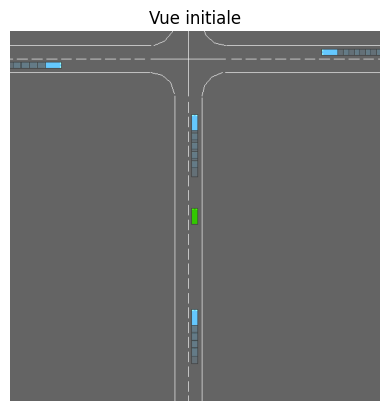

In [10]:
env = make_env()
env.unwrapped.configure(config)
obs, _ = env.reset()
frame = env.render()


plt.imshow(frame)
plt.axis("off")
plt.title("Vue initiale")
plt.show()

env.close()


In [11]:
# === Vectorize environment ===
vec_env = DummyVecEnv([make_env])

# === Define PPO model ===
model = PPO(
    "MlpPolicy",
    vec_env,
    policy_kwargs=dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])]),
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    learning_rate=5e-4,
    gamma=0.8,
    verbose=1,
    tensorboard_log="ppo_sb3_intersection_tensorboard/"
)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


Using cpu device


In [22]:
# === Train the model ===
model.learn(total_timesteps=100_000)
model.save("ppo_sb3_intersection_model")

Logging to ppo_sb3_intersection_tensorboard/PPO_2
-----------------------------
| time/              |      |
|    fps             | 14   |
|    iterations      | 1    |
|    time_elapsed    | 143  |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 13          |
|    iterations           | 2           |
|    time_elapsed         | 309         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011846902 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.0062      |
|    learning_rate        | 0.0005      |
|    loss                 | 1.54        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00886    |
|    value_loss           | 1.85        |
--------------------------

In [36]:
# === Evaluate the model ===
test_env = make_env()
mean_reward, std_reward = evaluate_policy(model, test_env, n_eval_episodes=20,
                                deterministic=True,
                                return_episode_rewards=False,
                                warn=False)
print(f"Evaluation over 20 EP: mean reward = {mean_reward:.2f} ± {std_reward:.2f}")



c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Evaluation over 20 EP: mean reward = 4.11 ± 4.70


In [35]:
print("Config lanes:", config["lanes_count"])  # should be 1
print("Config vehicles:", config["vehicles_count"])


Config lanes: 1
Config vehicles: 10


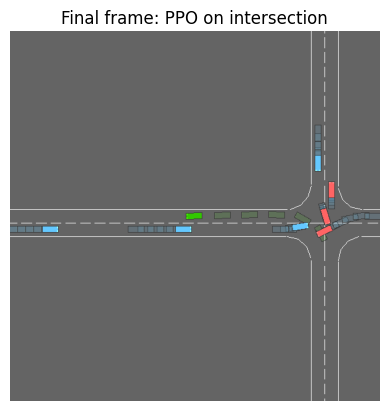

Total reward for 1 episode: 9.35


In [25]:
# === Visual test on one episode ===
obs, _ = test_env.reset()
done = False
frames = []
total_reward = 0
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = test_env.step(action)
    done = terminated or truncated
    total_reward += reward
    frame = test_env.render()
    frames.append(frame)

plt.imshow(frames[-1])
plt.axis("off")
plt.title("Final frame: PPO on intersection")
plt.show()
print(f"Total reward for 1 episode: {total_reward:.2f}")


In [48]:
import imageio

# === Visual test on one episode and save as GIF ===
obs, _ = test_env.reset()
done = False
frames = []
total_reward = 0

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = test_env.step(action)
    done = terminated or truncated
    total_reward += reward
    frame = test_env.render()  # RGB array
    frames.append(frame)



# Save to GIF
gif_path = "ppo_intersection_episode.gif"
imageio.mimsave(gif_path, frames, fps=15)  # 15 frames per second

print(f"Saved GIF to {gif_path}")
print(f"Total reward for 1 episode: {total_reward:.2f}")


Saved GIF to ppo_intersection_episode.gif
Total reward for 1 episode: 9.75



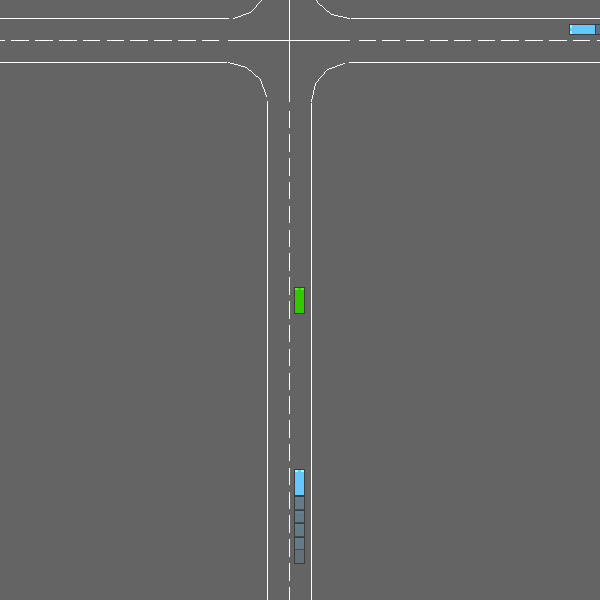

In [49]:
import base64, io
from IPython.display import HTML

def show_gif(frames, fps=30):
    import imageio, tempfile, os
    with tempfile.NamedTemporaryFile(suffix=".gif", delete=False) as fp:
        imageio.mimsave(fp.name, frames, fps=fps)
        data = base64.b64encode(open(fp.name,'rb').read()).decode("ascii")
    return HTML(f'<img src="data:image/gif;base64,{data}" />')
show_gif(frames, fps=30)

In [ ]:
import os
import glob
import numpy as np

from tensorboard.backend.event_processing import event_accumulator

# === DQN Log directory (change to "DQN_1" or "DQN_2" depending on run you want) ===
log_dir = "ppo_sb3_intersection_tensorboard/PPO_1"

# === Get the event file ===

event_file = glob.glob(os.path.join(log_dir, "events.out.tfevents.*"))[0]

# === Load and parse TensorBoard logs ===
ea = event_accumulator.EventAccumulator(event_file)
ea.Reload()




In [55]:
print(ea.Tags()["scalars"])


['time/fps', 'train/approx_kl', 'train/clip_fraction', 'train/clip_range', 'train/entropy_loss', 'train/explained_variance', 'train/learning_rate', 'train/loss', 'train/policy_gradient_loss', 'train/value_loss']


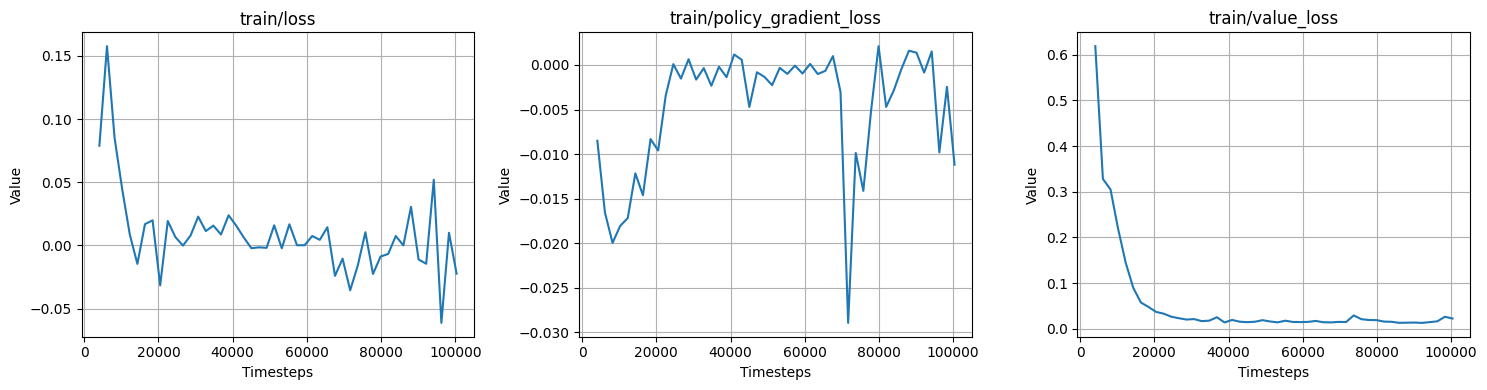

In [56]:
import matplotlib.pyplot as plt

metrics = ["train/loss", "train/policy_gradient_loss", "train/value_loss"]
plt.figure(figsize=(15, 4))

for i, tag in enumerate(metrics):
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]

    plt.subplot(1, 3, i+1)
    plt.plot(steps, values, label=tag.split("/")[-1])
    plt.xlabel("Timesteps")
    plt.ylabel("Value")
    plt.title(tag)
    plt.grid()

plt.tight_layout()
plt.show()
